https://www.datacamp.com/community/tutorials/networkx-python-graph-tutorial
https://networkx.github.io/documentation/stable/tutorial.html

In [23]:
#!pip install networkx

In [24]:
#!pip install community --user
#!pip install python-louvain --user

In [25]:
import itertools
import copy
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import community

### Read in the data

In [26]:
test_edge = pd.read_csv(
    '/Users/gracer/Google Drive/ABCD/ABCDworking/sub-NDARINV0A4ZDYNL/keep/sub-NDARINV0A4ZDYNL_ses-baselineYear1Arm1_task-rest_run-04_bold_brain_norm_zr_matrix.csv', header=None, 
                 index_col=False)

The edges here are Z transformed correlations, so theoretically the cut offs for p values should be useful

### Summary of the edges

In [27]:
summary_stats=test_edge.describe()
summary_stats

,0,1,2,3,4,5,6,7,8,9,...,254,255,256,257,258,259,260,261,262,263
count,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,...,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000
mean,0.906751,0.951428,0.915151,0.881726,0.865067,0.642449,0.571379,0.610091,0.616773,0.704128,...,0.053839,0.408512,-0.082585,-0.076030,0.064978,0.245709,-0.083044,-0.043231,0.537848,0.575540
std,0.695544,1.226706,0.581333,0.618805,0.682454,0.402549,0.370928,0.405676,0.367968,0.434621,...,0.507414,0.391335,0.228178,1.195018,0.437101,1.205280,0.492891,0.483061,0.474709,1.202034
min,-0.739829,-0.666353,-0.607088,-0.696913,-0.856208,-0.539843,-0.473686,-0.489685,-0.592648,-0.522273,...,-1.129569,-0.606568,-0.511894,-0.592648,-0.960836,-0.729830,-1.067589,-1.043059,-0.693013,-0.623456
25%,0.530965,0.594781,0.581904,0.542408,0.523346,0.441787,0.361311,0.306072,0.419379,0.467286,...,-0.204118,0.311615,-0.245937,-0.358919,-0.175576,-0.051971,-0.377564,-0.384354,0.309516,0.270394
50%,0.898305,0.935159,1.006421,0.952049,0.899272,0.669147,0.597558,0.593564,0.668106,0.720898,...,-0.081533,0.494826,-0.131701,-0.209792,-0.039682,0.091876,-0.203107,-0.142740,0.587484,0.560536
75%,1.319131,1.333461,1.314699,1.328814,1.310147,0.898921,0.775904,0.879549,0.850698,0.991125,...,0.163056,0.636727,0.033049,0.031661,0.189602,0.353685,0.082012,0.155193,0.886062,0.810108
max,2.524510,18.368400,2.047744,2.161540,2.436500,2.142545,2.142545,2.009574,1.662732,2.184207,...,2.502383,1.483239,1.356882,18.714974,1.770625,18.714974,1.770625,1.699516,1.661119,18.714974


### Read in the label file 

In [28]:
labels = pd.read_csv('/Users/gracer/Google Drive/ABCD/important_txt/locations.csv', sep=",")

In [29]:
labels.head()

,X,Y,Z,ID
0,-7,-52,61,Precuneus
1,-14,-18,40,Cingulate Gyrus
2,0,-15,47,Paracentral Lobule
3,10,-2,45,Cingulate Gyrus
4,-7,-21,65,Medial Frontal Gyrus


### Setting the indexes in pandas

In [30]:
test_edge=test_edge.set_index(labels.ID)
test_edge.rename(columns=labels.ID, inplace=True)

In [31]:
test_edge.shape

(264, 264)

### set all edges to positive

In [32]:
#test_edge=abs(test_edge)

In [33]:
test_edge.describe()

,Precuneus,Cingulate Gyrus,Paracentral Lobule,Cingulate Gyrus,Medial Frontal Gyrus,Postcentral Gyrus,Postcentral Gyrus,Postcentral Gyrus,Precentral Gyrus,Postcentral Gyrus,...,Superior Frontal Gyrus,Declive,Uvula,Tuber,Uncus,Uncus,Inferior Temporal Gyrus,Inferior Temporal Gyrus,Fusiform Gyrus,Fusiform Gyrus
count,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,...,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000
mean,0.906751,0.951428,0.915151,0.881726,0.865067,0.642449,0.571379,0.610091,0.616773,0.704128,...,0.053839,0.408512,-0.082585,-0.076030,0.064978,0.245709,-0.083044,-0.043231,0.537848,0.575540
std,0.695544,1.226706,0.581333,0.618805,0.682454,0.402549,0.370928,0.405676,0.367968,0.434621,...,0.507414,0.391335,0.228178,1.195018,0.437101,1.205280,0.492891,0.483061,0.474709,1.202034
min,-0.739829,-0.666353,-0.607088,-0.696913,-0.856208,-0.539843,-0.473686,-0.489685,-0.592648,-0.522273,...,-1.129569,-0.606568,-0.511894,-0.592648,-0.960836,-0.729830,-1.067589,-1.043059,-0.693013,-0.623456
25%,0.530965,0.594781,0.581904,0.542408,0.523346,0.441787,0.361311,0.306072,0.419379,0.467286,...,-0.204118,0.311615,-0.245937,-0.358919,-0.175576,-0.051971,-0.377564,-0.384354,0.309516,0.270394
50%,0.898305,0.935159,1.006421,0.952049,0.899272,0.669147,0.597558,0.593564,0.668106,0.720898,...,-0.081533,0.494826,-0.131701,-0.209792,-0.039682,0.091876,-0.203107,-0.142740,0.587484,0.560536
75%,1.319131,1.333461,1.314699,1.328814,1.310147,0.898921,0.775904,0.879549,0.850698,0.991125,...,0.163056,0.636727,0.033049,0.031661,0.189602,0.353685,0.082012,0.155193,0.886062,0.810108
max,2.524510,18.368400,2.047744,2.161540,2.436500,2.142545,2.142545,2.009574,1.662732,2.184207,...,2.502383,1.483239,1.356882,18.714974,1.770625,18.714974,1.770625,1.699516,1.661119,18.714974


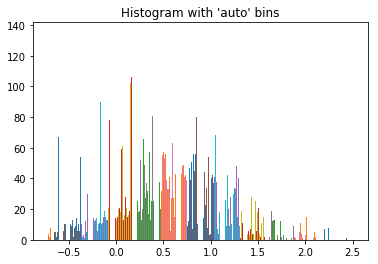

In [34]:
#extracts the indices from the correlation matrix, which are the stocks
edge_names = test_edge.index.values

#Changes from dataframe to matrix, so it is easier to create a graph with networkx
cor_matrix = np.asmatrix(test_edge)
np.amax(cor_matrix)
np.amin(cor_matrix)
plt.hist(cor_matrix, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()
#setting a threshold
#super_threshold_indices = cor_matrix < 1.64485
#cor_matrix[super_threshold_indices] = 0
#print(cor_matrix)

In [35]:
#Crates graph using the data of the correlation matrix
G = nx.from_numpy_matrix(cor_matrix)

### adding label info to the node

In [36]:
for i, nlrow in labels.iterrows():
    G.node[i].update(nlrow[0:].to_dict())

### Basic plot

In [37]:
def create_corr_network_1(G):
    #crates a list for edges and for the weights
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

    #positions
    positions=nx.circular_layout(G)
    
    #Figure size
    plt.figure(figsize=(15,15))

    #draws nodes
    nx.draw_networkx_nodes(G,positions,node_color='#DA70D6',
                           node_size=500,alpha=0.8)
    
    #Styling for labels
    nx.draw_networkx_labels(G, positions, font_size=8, 
                            font_family='sans-serif')
        
    #draws the edges
    nx.draw_networkx_edges(G, positions, edge_list=edges,style='solid')
    
    # displays the graph without axis
    plt.axis('off')
    #saves image
    plt.savefig("part1.png", format="PNG")
    plt.show() 

#create_corr_network_1(G)

### Creating a nodelist and getting the sizes

In [38]:
d = nx.degree(G)
list(d)[0]
nodelist, node_sizes = zip(*list(d))

### Caluclating the Functional connectivity
This is the mean of all non-negative elements in the matrix

In [39]:
x=abs(cor_matrix)
x.mean()

0.7027660155532597

### function to create and display networks from the correlation matrix. 

In [40]:
def create_corr_network_5(G, corr_direction, min_correlation):
    ##Creates a copy of the graph
    H = G.copy()
    
    ##Checks all the edges and removes some based on corr_direction
    for stock1, stock2, weight in list(G.edges(data=True)):
        ##if we only want to see the positive correlations we then delete the edges with weight smaller than 0        
        if corr_direction == "positive":
            ####it adds a minimum value for correlation. 
            ####If correlation weaker than the min, then it deletes the edge
            if weight["weight"] <0 or weight["weight"] < min_correlation:
                H.remove_edge(stock1, stock2)
        ##this part runs if the corr_direction is negative and removes edges with weights equal or largen than 0
        else:
            ####it adds a minimum value for correlation. 
            ####If correlation weaker than the min, then it deletes the edge
            if weight["weight"] >=0 or weight["weight"] > min_correlation:
                H.remove_edge(stock1, stock2)
                
    
    #crates a list for edges and for the weights
    edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
    
    ### increases the value of weights, so that they are more visible in the graph
    weights = tuple([(1+abs(x))**1 for x in weights])
    
    #####calculates the degree of each node
    d = nx.degree(H)
    #####creates list of nodes and a list their degrees that will be used later for their sizes
    nodelist, node_sizes = zip(*list(d))

    #positions
    positions=nx.circular_layout(H)
    
    #Figure size
    plt.figure(figsize=(15,15))

    #draws nodes
    nx.draw_networkx_nodes(H,positions,node_color='blue',nodelist=nodelist,
                           #####the node size will be now based on its degree
                           node_size=tuple([x**1 for x in node_sizes]),alpha=0.8)
    
    #Styling for labels
    nx.draw_networkx_labels(H, positions, font_size=8, 
                            font_family='sans-serif')
    
    ###edge colors based on weight direction
    if corr_direction == "positive":
        edge_colour = plt.cm.GnBu 
    else:
        edge_colour = plt.cm.PuRd
        
    #draws the edges
    nx.draw_networkx_edges(H, positions, edge_list=edges,style='solid',
                          ###adds width=weights and edge_color = weights 
                          ###so that edges are based on the weight parameter 
                          ###edge_cmap is for the color scale based on the weight
                          ### edge_vmin and edge_vmax assign the min and max weights for the width
                          width=weights, edge_color = weights, edge_cmap = edge_colour,
                          edge_vmin = min(weights), edge_vmax=max(weights))

    # displays the graph without axis
    plt.axis('off')
    #saves image
    plt.savefig("part5" + corr_direction + ".png", format="PNG")
    plt.show() 
    return(H)


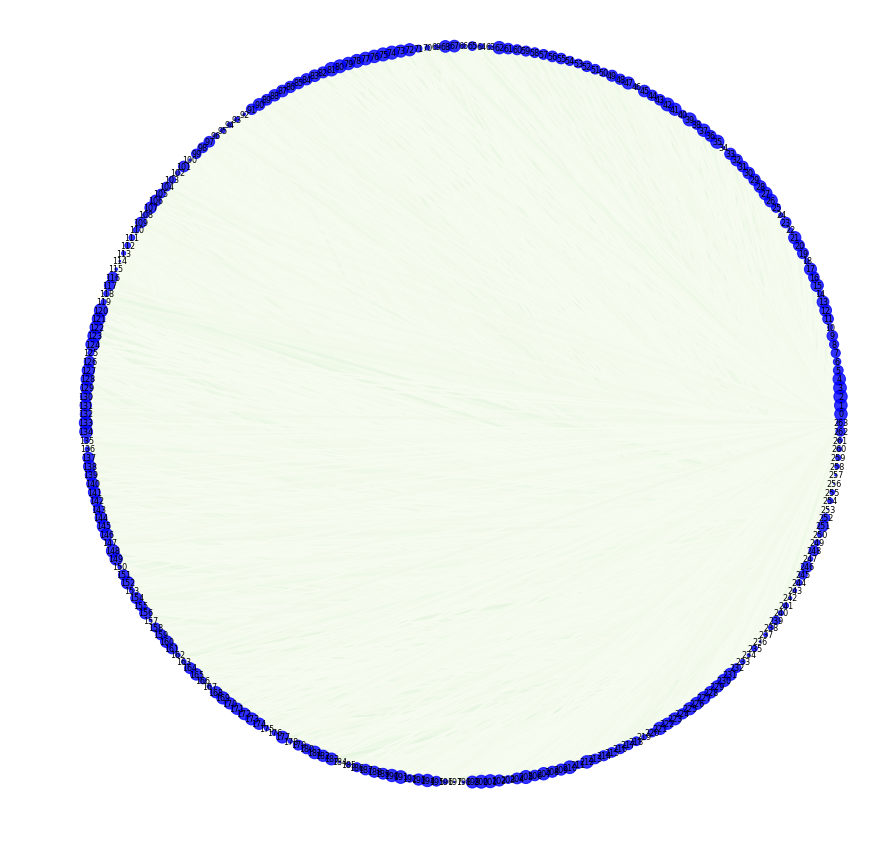

In [41]:
H=create_corr_network_5(G, "positive", 0.8)

In [42]:
len(H.nodes)

264

### Getting the modularity

In [43]:
partition = community.best_partition(H)
partition.values()

AttributeError: module 'community' has no attribute 'best_partition'

In [ ]:
community.modularity(partition, H)

In [ ]:
#drawing
size = float(len(set(partition.values())))
print(size)
pos = nx.spring_layout(H)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(H, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(H, pos, alpha=0.1)
plt.show()

In [ ]:
g=community.induced_graph(partition,H)
create_corr_network_1(G=g)

In [ ]:
print('# of edges: {}'.format(H.number_of_edges()))
print('# of nodes: {}'.format(H.number_of_nodes()))

In [ ]:
# Define node positions data structure (dict) for plotting
node_positions = {node[0]: (node[1]['X'], -node[1]['Y'], -node[1]['Z']) for node in H.nodes(data=True)}

# Preview of node_positions with a bit of hack (there is no head/slice method for dictionaries).
dict(list(node_positions.items())[0:5])

In [ ]:
print(partition)

color_dic = {0:'blue',1:'red',2:'green',3:'purple',4:'yellow',5:'pink',6:'black',7:'orange', 8:'cyan'}

In [ ]:
for key, value in partition.items():
    partition[key]=(color_dic[value])
print(partition)

need to figure out how to get it more sparse  
add colors  


In [ ]:
nx.draw(H)
plt.show() # display

In [ ]:
list(H.edges(data=True))[0:5]

In [ ]:
list(H.nodes(data=True))[0:5]

In [ ]:
for key, value in partition.items():
    print("this is the key %s"%key)
    print(value)
    print(H.node(data=True)[key])
    H.node(data=True)[key].update({'color':value})

In [ ]:
list(H.edges(data=True))[0]
H.edges(data=True)
edge_weights = [e[2]['weight'] for e in H.edges(data=True)]


In [ ]:
edge_weights

In [ ]:
# Define node positions data structure (dict) for plotting
node_positions = {node[0]: (node[1]['X'], -node[1]['Y']) for node in H.nodes(data=True)}
node_colors = {node[0]: (node[1]['color']) for node in H.nodes(data=True)}

# Preview of node_positions with a bit of hack (there is no head/slice method for dictionaries).
#dict(list(node_colors.items())[0:5])
#print(G.node(data=True))
list_colors=list(node_colors.values())

In [ ]:
plt.figure(figsize=(8, 6))
nx.draw(H, pos=node_positions,  node_size=node_sizes,  edge_color = "grey", node_color = list_colors)
plt.title('Graph Test', size=15)
plt.show()

In [ ]:
len(node_sizes)
max(node_sizes)